https://www.pyimagesearch.com/2020/03/09/grad-cam-visualize-class-activation-maps-with-keras-tensorflow-and-deep-learning



## Utility functions

In [1]:
from functools import wraps 

# function to add class methods dynamically
def add_method(cls):
    def decorator(func):
        @wraps(func) 
        def wrapper(self, *args, **kwargs): 
            return func(self, *args, **kwargs)
        setattr(cls, func.__name__, wrapper)
        # Note we are not binding func, but wrapper which accepts self but does exactly the same as func
        return func # returning func means func can still be used normally
    return decorator

## Building GradCAM 

## Import libraries

In [2]:
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
import cv2

## Create an empty GradCAM Class

In [3]:
class GradCAM:
    pass  

## Creating the Constructor

The constructor accepts and stores:

- A TensorFlow model which we’ll use to compute a heatmap
- The classIdx — a specific class index that we’ll use to measure our class activation heatmap
- An optional CONV layerName of the model in case we want to visualize the heatmap of a specific layer of our CNN; otherwise, if a specific layer name is not provided, we will automatically infer on the final CONV/POOL layer of the model architecture 

In [4]:
@add_method(GradCAM)
def __init__(self, model, classIdx, layerName=None):

    # store the model, the class index used to measure the class
    # activation map, and the layer to be used when visualizing
    # the class activation map
    self.model = model
    self.classIdx = classIdx
    self.layerName = layerName

    # if the layer name is None, attempt to automatically find
    # the target output layer
    if self.layerName is None:
        self.layerName = self.find_target_layer()

## Adding function to find target layer

The `find_target_layer()` function loops over all layers in the network in reverse order, during which time it checks to see if the current layer has a 4D output (implying a CONV or POOL layer).

If find such a 4D output, we return that layer name.

Otherwise, if the network does not have a 4D output, then we cannot apply Grad-CAM, at which point, we raise a ValueError exception, causing our program to stop

In [5]:
@add_method(GradCAM)
def find_target_layer(self):

    # attempt to find the final convolutional layer in the network
    # by looping over the layers of the network in reverse order
    for layer in reversed(self.model.layers):
        # check to see if the layer has a 4D output
        if len(layer.output_shape) == 4:
            return layer.name
            
    # otherwise, we could not find a 4D layer so the GradCAM
    # algorithm cannot be applied
    raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")

## Adding function to construct GradCAM heatmap

In [6]:
@add_method(GradCAM)
def compute_heatmap(self, image, eps=1e-8, verbose=False):

    # Step 1:
    # construct our gradient model by supplying 
    # (1) the inputs to our pre-trained model
    # (2) the output of the (presumably) final 4D layer in the network
    # (3) the output of the softmax activations from the model
    gradModel = Model(
        inputs=[self.model.inputs],
        outputs=[self.model.get_layer(self.layerName).output,
            self.model.output])
    if verbose:
        print('\nStep 1:')
        print('Model:', self.model.name)
        print('Conv layerName:', self.layerName)
        print('Conv Layer Shape:', gradModel.outputs[0].shape)
    

    # Step 2:
    # record operations for automatic differentiation
    with tf.GradientTape() as tape:

        # cast the image tensor to a float-32 data type, pass the
        # image through the gradient model, and grab the loss
        # associated with the specific class index
        inputs = tf.cast(image, tf.float32)
        (convOutputs, predictions) = gradModel(inputs)
        loss = predictions[:, self.classIdx]
    
    # use automatic differentiation to compute the gradients
    grads = tape.gradient(loss, convOutputs)
    if verbose:
        print('\nStep 2:')
        print('loss:', loss)
        print('convOutputs shape;', convOutputs.shape)
        print('gradients shape:', grads.shape)
  

    # Step 3:  
    # compute the guided gradients
    castConvOutputs = tf.cast(convOutputs > 0, "float32")
    castGrads = tf.cast(grads > 0, "float32")
    guidedGrads = castConvOutputs * castGrads * grads
    if verbose:
        print('\nStep 3')
        print('guidedGrads shape', guidedGrads.shape)

    # the convolution and guided gradients have a batch dimension
    # (which we don't need) so let's grab the volume itself and
    # discard the batch
    convOutputs = convOutputs[0]
    guidedGrads = guidedGrads[0]
    if verbose:
        print('guidedGrads shape batch removal', guidedGrads.shape)
        print('convOutputs shape batch removal', convOutputs.shape)


    # Step 4:
    # compute the average of the gradient values, and using them
    # as weights, compute the ponderation of the filters with
    # respect to the weights
    weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
    if verbose:
        print('\nStep 4:')
        print('weights shape:', weights.shape)
        print('cam shape:', cam.shape)


    # Step 5:
    # grab the spatial dimensions of the input image and resize
    # the output class activation map to match the input image
    # dimensions
    (w, h) = (image.shape[2], image.shape[1])
    heatmap = cv2.resize(cam.numpy(), (w, h))

    # normalize the heatmap such that all values lie in the range
    # [0, 1], scale the resulting values to the range [0, 255],
    # and then convert to an unsigned 8-bit integer
    numer = heatmap - np.min(heatmap)
    denom = (heatmap.max() - heatmap.min()) + eps
    heatmap = numer / denom
    heatmap = (heatmap * 255).astype("uint8")
    if verbose:
        print('\nStep 5:')
        print('heatmap shape:', heatmap.shape)

    # return the resulting heatmap to the calling function
    return heatmap

## Adding function to overlay heatmap on the image

Our heatmap produced by the previous compute_heatmap function is a single channel, grayscale representation of where the network activated in the image — larger values correspond to a higher activation, smaller values to a lower activation.

In order to overlay the heatmap, we first need to apply a pseudo/false-color to the heatmap. To do so, we will use OpenCV’s built in `VIRIDIS` colormap (i.e., `cv2.COLORMAP_VIRIDIS`).

In [7]:
@add_method(GradCAM)
def overlay_heatmap(self, heatmap, image, alpha=0.5, 
                    colormap=cv2.COLORMAP_VIRIDIS):
    
    # apply the supplied color map to the heatmap and then
    # overlay the heatmap on the input image
    heatmap = cv2.applyColorMap(heatmap, colormap)
    output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
    
    # return a 2-tuple of the color mapped heatmap and the output,
    # overlaid image
    return (heatmap, output)

## Applying GradCAM

## Import libraries

In [8]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import EfficientNetV2L
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications import imagenet_utils
import numpy as np
import cv2
import matplotlib.pyplot as plt

## Load Pre-trained Models

In [9]:
vgg_model = VGG16(weights='imagenet')
resnet50_model = ResNet50(weights='imagenet')
efficientnetv2l_model = EfficientNetV2L(weights='imagenet')

## Helper Functions - Image Utilities

In [10]:
# helper function for image pre-processing
def image_processing_function(im_path, size):
  # load the original image from gdrive (in OpenCV format)
  # resize the image to its target dimensions

  orig = cv2.imread(im_path)
  orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)  

  # load the input image from gdrive (in Keras/TensorFlow format)
  # basic image pre-processing

  image = load_img(im_path, target_size=size)
  image = img_to_array(image)
  image = np.expand_dims(image, axis=0)
  image = imagenet_utils.preprocess_input(image)

  return image, orig


# helper function to get predicted classes
def get_class_predictions(preds, class_rank):
  rank = class_rank
  classes_ranked = np.argsort(preds[0])[::-1]
  i = classes_ranked[rank]

  decoded = imagenet_utils.decode_predictions(preds, 10)
  (imagenetID, label, prob) = decoded[0][0]

  label = "{}: {:.2f}%".format(label, prob * 100)
  print('Class with highest probability:')
  print("{}".format(label))

  return i, decoded

## VGG16 Interpretation Flow

### Load and Pre-process Image

In [63]:
!wget -O mantis.jpg https://media.npr.org/assets/img/2016/12/13/12089785554_46dd58b9c9_z_custom-292610179dd5cc6b99ec1b1e7832651cb789d7fe.jpg

--2023-02-26 19:20:06--  https://media.npr.org/assets/img/2016/12/13/12089785554_46dd58b9c9_z_custom-292610179dd5cc6b99ec1b1e7832651cb789d7fe.jpg
Resolving media.npr.org (media.npr.org)... 23.0.250.132, 2a02:26f0:6d00:6a4::1155, 2a02:26f0:6d00:691::1155
Connecting to media.npr.org (media.npr.org)|23.0.250.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 83194 (81K) [image/jpeg]
Saving to: ‘mantis.jpg’

mantis.jpg          100%[===================>]  81.24K  --.-KB/s    in 0.008s  

2023-02-26 19:20:06 (9.55 MB/s) - ‘mantis.jpg’ saved [83194/83194]



In [64]:
# define path to image
im_path = './mantis.jpg'

# use helper function for image pre-processing
image, orig = image_processing_function(im_path, (224, 224))

### Run VGG Inference 

In [65]:
# use the network to make predictions on the input image and find
preds = vgg_model.predict(image)

1/1 [==============================] - 1s 663ms/step


In [66]:
# get classes
idx, decoded = get_class_predictions(preds, 0)

Class with highest probability:
cricket: 27.63%


In [67]:
decoded

[[('n02229544', 'cricket', 0.2762556),
  ('n02177972', 'weevil', 0.23393916),
  ('n02264363', 'lacewing', 0.18111826),
  ('n02168699', 'long-horned_beetle', 0.064709045),
  ('n02226429', 'grasshopper', 0.06063619),
  ('n02259212', 'leafhopper', 0.053204812),
  ('n02169497', 'leaf_beetle', 0.038828596),
  ('n02233338', 'cockroach', 0.008230733),
  ('n02219486', 'ant', 0.0080336295),
  ('n02236044', 'mantis', 0.0074461014)]]

In [68]:
idx

312

### Initialize GradCAM instance

In [69]:
vgg_gc = GradCAM(model=vgg_model, classIdx=idx)

In [70]:
for l in vgg_gc.model.layers:
  print(l.name)

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool
flatten
fc1
fc2
predictions


### Get GradCAM heatmap

In [71]:
heatmap = vgg_gc.compute_heatmap(image, verbose=True)
# resize the resulting heatmap to the original input image dimensions
# overlay heatmap on top of the image
heatmap = cv2.resize(heatmap, (orig.shape[1], orig.shape[0]))
(heatmap, output) = vgg_gc.overlay_heatmap(heatmap, orig, alpha=0.35)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)  
output = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)  


Step 1:
Model: vgg16
Conv layerName: block5_pool
Conv Layer Shape: (None, 7, 7, 512)

Step 2:
loss: tf.Tensor([0.2762556], shape=(1,), dtype=float32)
convOutputs shape; (1, 7, 7, 512)
gradients shape: (1, 7, 7, 512)

Step 3
guidedGrads shape (1, 7, 7, 512)
guidedGrads shape batch removal (7, 7, 512)
convOutputs shape batch removal (7, 7, 512)

Step 4:
weights shape: (512,)
cam shape: (7, 7)

Step 5:
heatmap shape: (224, 224)


### "The cricket"

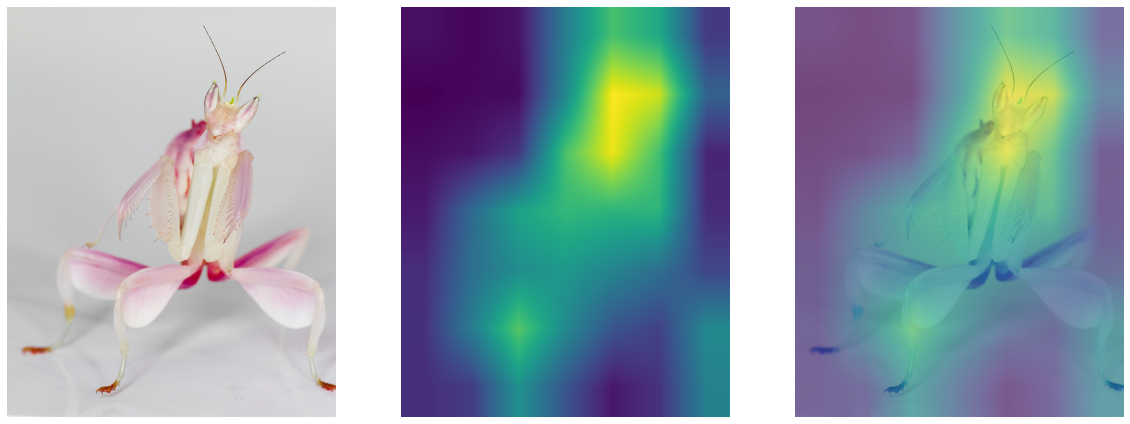

In [72]:
f, ax = plt.subplots(1,3, figsize=(20, 10))

plt.axis('off'); 
ax[0].imshow(orig); 
ax[1].imshow(heatmap); 
ax[2].imshow(output); 
[axi.set_axis_off() for axi in ax.ravel()];

### What else VGG16 sees in the image 

In [73]:
decoded = imagenet_utils.decode_predictions(preds, 1000)[0]

In [74]:
idx = [s for _, s, _ in decoded[:]].index('mantis')

In [75]:
decoded[idx]

('n02236044', 'mantis', 0.0074461014)

In [76]:
for l in vgg_gc.model.layers:
  print(l.name)

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool
flatten
fc1
fc2
predictions


In [77]:
vgg_gc = GradCAM(model=vgg_model, classIdx=idx, layerName='block5_conv3')

In [78]:
heatmap = vgg_gc.compute_heatmap(image, verbose=True)
# resize the resulting heatmap to the original input image dimensions
# overlay heatmap on top of the image
heatmap = cv2.resize(heatmap, (orig.shape[1], orig.shape[0]))
(heatmap, output) = vgg_gc.overlay_heatmap(heatmap, orig, alpha=0.35)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)  
output = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)  


Step 1:
Model: vgg16
Conv layerName: block5_conv3
Conv Layer Shape: (None, 14, 14, 512)

Step 2:
loss: tf.Tensor([6.590273e-08], shape=(1,), dtype=float32)
convOutputs shape; (1, 14, 14, 512)
gradients shape: (1, 14, 14, 512)

Step 3
guidedGrads shape (1, 14, 14, 512)
guidedGrads shape batch removal (14, 14, 512)
convOutputs shape batch removal (14, 14, 512)

Step 4:
weights shape: (512,)
cam shape: (14, 14)

Step 5:
heatmap shape: (224, 224)


### The mantis

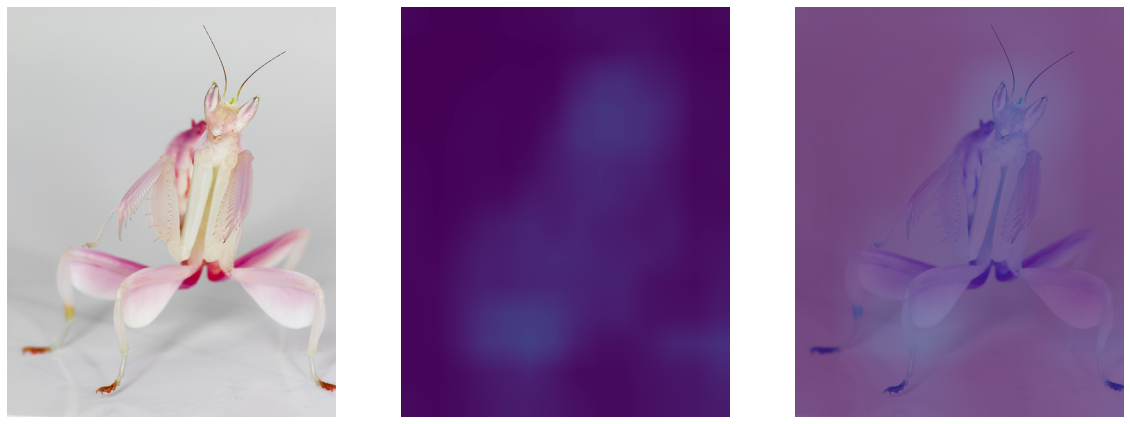

In [79]:
f, ax = plt.subplots(1,3, figsize=(20, 10))

plt.axis('off'); 
ax[0].imshow(orig); 
ax[1].imshow(heatmap); 
ax[2].imshow(output); 
[axi.set_axis_off() for axi in ax.ravel()];

## ResNet50 Interpretation Flow

### Load and Pre-process Image

In [134]:
!wget -O mantis.jpg https://media.npr.org/assets/img/2016/12/13/12089785554_46dd58b9c9_z_custom-292610179dd5cc6b99ec1b1e7832651cb789d7fe.jpg

--2023-02-26 19:28:15--  https://media.npr.org/assets/img/2016/12/13/12089785554_46dd58b9c9_z_custom-292610179dd5cc6b99ec1b1e7832651cb789d7fe.jpg
Resolving media.npr.org (media.npr.org)... 23.206.87.21, 2a02:26f0:c900:29f::1155, 2a02:26f0:c900:284::1155
Connecting to media.npr.org (media.npr.org)|23.206.87.21|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 83194 (81K) [image/jpeg]
Saving to: ‘mantis.jpg’

mantis.jpg          100%[===================>]  81.24K  --.-KB/s    in 0.008s  

2023-02-26 19:28:16 (9.65 MB/s) - ‘mantis.jpg’ saved [83194/83194]



In [135]:
# define path to image
im_path = './mantis.jpg'

# use helper function for image pre-processing
image, orig = image_processing_function(im_path, (224, 224))

### Run ResNet50 Inference

In [136]:
# use the network to make predictions on the input image and find
preds = resnet50_model.predict(image)

1/1 [==============================] - 0s 253ms/step


In [137]:
# get classes
idx, decoded = get_class_predictions(preds, 0)

Class with highest probability:
lacewing: 48.97%


In [138]:
# lets look at other possible classes 
decoded

[[('n02264363', 'lacewing', 0.48965982),
  ('n02236044', 'mantis', 0.18350323),
  ('n02226429', 'grasshopper', 0.14944936),
  ('n02229544', 'cricket', 0.115305915),
  ('n02233338', 'cockroach', 0.009984192),
  ('n02169497', 'leaf_beetle', 0.0073955604),
  ('n02280649', 'cabbage_butterfly', 0.004944754),
  ('n02206856', 'bee', 0.003984649),
  ('n02168699', 'long-horned_beetle', 0.0037019083),
  ('n02190166', 'fly', 0.003630456)]]

In [139]:
idx

318

### Initialize GradCAM instance

In [140]:
resnet_gc = GradCAM(model=resnet50_model, classIdx=idx)

In [141]:
for l in resnet_gc.model.layers[-25:]:
  print(l.name)

conv5_block1_3_bn
conv5_block1_add
conv5_block1_out
conv5_block2_1_conv
conv5_block2_1_bn
conv5_block2_1_relu
conv5_block2_2_conv
conv5_block2_2_bn
conv5_block2_2_relu
conv5_block2_3_conv
conv5_block2_3_bn
conv5_block2_add
conv5_block2_out
conv5_block3_1_conv
conv5_block3_1_bn
conv5_block3_1_relu
conv5_block3_2_conv
conv5_block3_2_bn
conv5_block3_2_relu
conv5_block3_3_conv
conv5_block3_3_bn
conv5_block3_add
conv5_block3_out
avg_pool
predictions


### Get GradCAM heatmap

In [142]:
heatmap = resnet_gc.compute_heatmap(image, verbose=True)
# resize the resulting heatmap to the original input image dimensions
# overlay heatmap on top of the image
heatmap = cv2.resize(heatmap, (orig.shape[1], orig.shape[0]))
(heatmap, output) = resnet_gc.overlay_heatmap(heatmap, orig, alpha=0.35)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)  
output = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)  


Step 1:
Model: resnet50
Conv layerName: conv5_block3_out
Conv Layer Shape: (None, 7, 7, 2048)

Step 2:
loss: tf.Tensor([0.48965982], shape=(1,), dtype=float32)
convOutputs shape; (1, 7, 7, 2048)
gradients shape: (1, 7, 7, 2048)

Step 3
guidedGrads shape (1, 7, 7, 2048)
guidedGrads shape batch removal (7, 7, 2048)
convOutputs shape batch removal (7, 7, 2048)

Step 4:
weights shape: (2048,)
cam shape: (7, 7)

Step 5:
heatmap shape: (224, 224)


### The "lacewing"

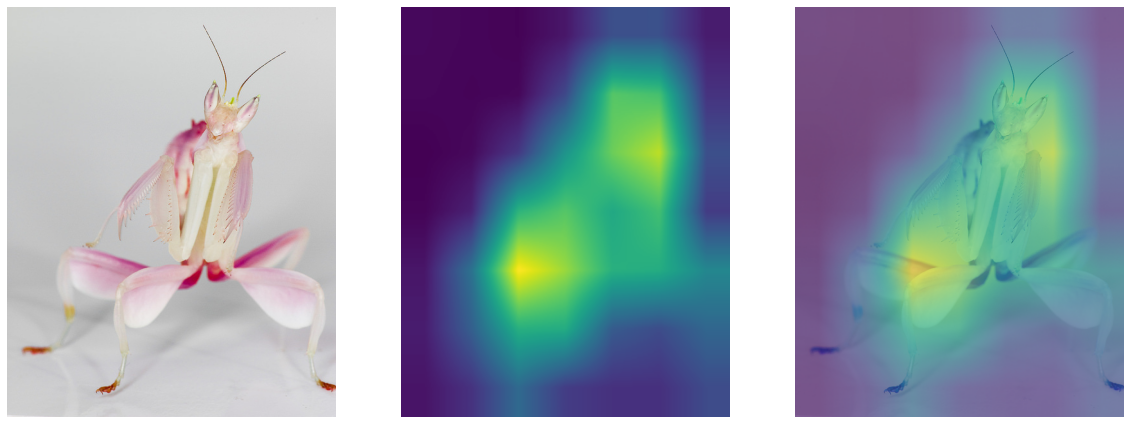

In [143]:
f, ax = plt.subplots(1,3, figsize=(20, 10))

plt.axis('off'); 
ax[0].imshow(orig); 
ax[1].imshow(heatmap); 
ax[2].imshow(output); 
[axi.set_axis_off() for axi in ax.ravel()];

### What else ResNet50 sees in the image

In [144]:
decoded = imagenet_utils.decode_predictions(preds, 1000)[0]

In [145]:
idx = [s for _, s, _ in decoded[:]].index('mantis')

In [146]:
decoded[idx]

('n02236044', 'mantis', 0.18350323)

In [147]:
for l in resnet_gc.model.layers[-25:]:
  print(l.name)

conv5_block1_3_bn
conv5_block1_add
conv5_block1_out
conv5_block2_1_conv
conv5_block2_1_bn
conv5_block2_1_relu
conv5_block2_2_conv
conv5_block2_2_bn
conv5_block2_2_relu
conv5_block2_3_conv
conv5_block2_3_bn
conv5_block2_add
conv5_block2_out
conv5_block3_1_conv
conv5_block3_1_bn
conv5_block3_1_relu
conv5_block3_2_conv
conv5_block3_2_bn
conv5_block3_2_relu
conv5_block3_3_conv
conv5_block3_3_bn
conv5_block3_add
conv5_block3_out
avg_pool
predictions


In [148]:
resnet_gc = GradCAM(model=resnet50_model, classIdx=idx)

In [149]:
heatmap = resnet_gc.compute_heatmap(image, verbose=True)
# resize the resulting heatmap to the original input image dimensions
# overlay heatmap on top of the image
heatmap = cv2.resize(heatmap, (orig.shape[1], orig.shape[0]))
(heatmap, output) = resnet_gc.overlay_heatmap(heatmap, orig, alpha=0.35)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)  
output = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)  


Step 1:
Model: resnet50
Conv layerName: conv5_block3_out
Conv Layer Shape: (None, 7, 7, 2048)

Step 2:
loss: tf.Tensor([9.653e-05], shape=(1,), dtype=float32)
convOutputs shape; (1, 7, 7, 2048)
gradients shape: (1, 7, 7, 2048)

Step 3
guidedGrads shape (1, 7, 7, 2048)
guidedGrads shape batch removal (7, 7, 2048)
convOutputs shape batch removal (7, 7, 2048)

Step 4:
weights shape: (2048,)
cam shape: (7, 7)

Step 5:
heatmap shape: (224, 224)


### The mantis

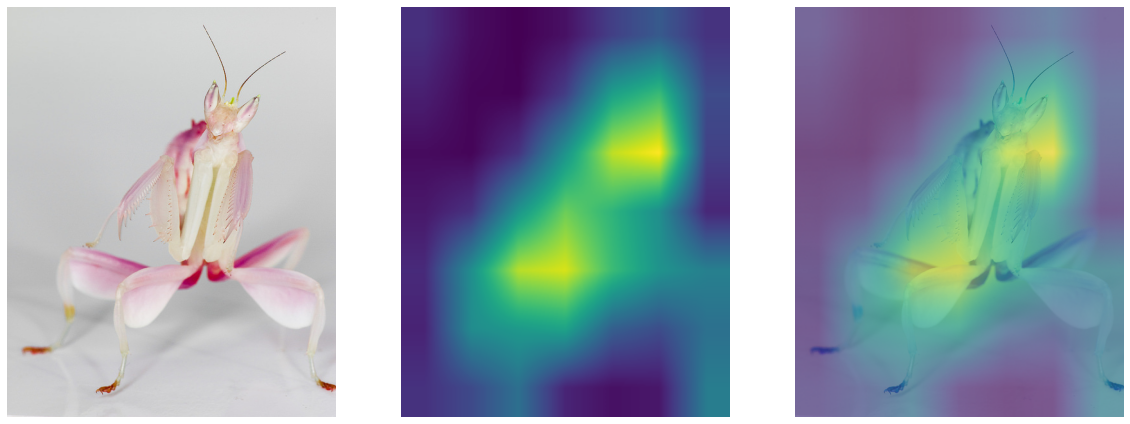

In [150]:
f, ax = plt.subplots(1,3, figsize=(20, 10))

plt.axis('off'); 
ax[0].imshow(orig); 
ax[1].imshow(heatmap); 
ax[2].imshow(output); 
[axi.set_axis_off() for axi in ax.ravel()];

## EfficientNetV2L Interpretation Flow

### Load and Pre-process Image

In [153]:
!wget -O mantis.jpg https://media.npr.org/assets/img/2016/12/13/12089785554_46dd58b9c9_z_custom-292610179dd5cc6b99ec1b1e7832651cb789d7fe.jpg

--2023-02-26 19:38:13--  https://media.npr.org/assets/img/2016/12/13/12089785554_46dd58b9c9_z_custom-292610179dd5cc6b99ec1b1e7832651cb789d7fe.jpg
Resolving media.npr.org (media.npr.org)... 92.122.62.164, 2a02:26f0:c900:29f::1155, 2a02:26f0:c900:284::1155
Connecting to media.npr.org (media.npr.org)|92.122.62.164|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 83194 (81K) [image/jpeg]
Saving to: ‘mantis.jpg’

mantis.jpg          100%[===================>]  81.24K  --.-KB/s    in 0.007s  

2023-02-26 19:38:13 (10.9 MB/s) - ‘mantis.jpg’ saved [83194/83194]



In [154]:
# define path to image
im_path = './mantis.jpg'

# use helper function for image pre-processing
image, orig = image_processing_function(im_path, (480, 480))

### Run EfficientNetV2L Inference 

In [155]:
# use the network to make predictions on the input image and find
preds = efficientnetv2l_model.predict(image)

1/1 [==============================] - 3s 3s/step


In [156]:
# get classes
idx, decoded = get_class_predictions(preds, 0)

Class with highest probability:
mantis: 83.70%


In [157]:
decoded

[[('n02236044', 'mantis', 0.8370351),
  ('n02231487', 'walking_stick', 0.0054960493),
  ('n02226429', 'grasshopper', 0.0017808686),
  ('n02229544', 'cricket', 0.0016525717),
  ('n02259212', 'leafhopper', 0.0009970047),
  ('n02264363', 'lacewing', 0.00062590337),
  ('n02219486', 'ant', 0.0005783686),
  ('n02233338', 'cockroach', 0.0005275853),
  ('n02256656', 'cicada', 0.0005053439),
  ('n02051845', 'pelican', 0.0004714662)]]

In [158]:
idx

315

### Initialize GradCAM instance

In [159]:
efficientnetv2l_gc = GradCAM(model=efficientnetv2l_model, classIdx=idx)

In [160]:
for l in efficientnetv2l_gc.model.layers[-25:]:
  print(l.name)

block7f_project_conv
block7f_project_bn
block7f_drop
block7f_add
block7g_expand_conv
block7g_expand_bn
block7g_expand_activation
block7g_dwconv2
block7g_bn
block7g_activation
block7g_se_squeeze
block7g_se_reshape
block7g_se_reduce
block7g_se_expand
block7g_se_excite
block7g_project_conv
block7g_project_bn
block7g_drop
block7g_add
top_conv
top_bn
top_activation
avg_pool
top_dropout
predictions


### Get GradCAM heatmap

In [161]:
heatmap = efficientnetv2l_gc.compute_heatmap(image, verbose=True)
# resize the resulting heatmap to the original input image dimensions
# overlay heatmap on top of the image
heatmap = cv2.resize(heatmap, (orig.shape[1], orig.shape[0]))
(heatmap, output) = efficientnetv2l_gc.overlay_heatmap(heatmap, orig, alpha=0.35)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)  
output = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)  


Step 1:
Model: efficientnetv2-l
Conv layerName: top_activation
Conv Layer Shape: (None, 15, 15, 1280)

Step 2:
loss: tf.Tensor([0.8370351], shape=(1,), dtype=float32)
convOutputs shape; (1, 15, 15, 1280)
gradients shape: (1, 15, 15, 1280)

Step 3
guidedGrads shape (1, 15, 15, 1280)
guidedGrads shape batch removal (15, 15, 1280)
convOutputs shape batch removal (15, 15, 1280)

Step 4:
weights shape: (1280,)
cam shape: (15, 15)

Step 5:
heatmap shape: (480, 480)


### The mantis

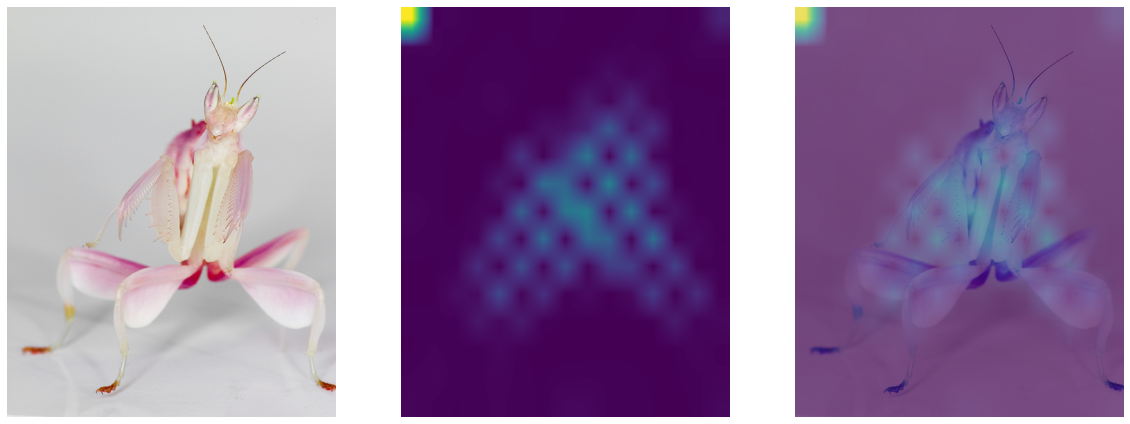

In [162]:
f, ax = plt.subplots(1,3, figsize=(20, 10))

plt.axis('off'); 
ax[0].imshow(orig); 
ax[1].imshow(heatmap); 
ax[2].imshow(output); 
[axi.set_axis_off() for axi in ax.ravel()];

### Lower layers

In [163]:
efficientnetv2l_gc = GradCAM(model=efficientnetv2l_model, classIdx=idx, layerName='block7d_project_conv')

In [164]:
heatmap = efficientnetv2l_gc.compute_heatmap(image, verbose=True)
# resize the resulting heatmap to the original input image dimensions
# overlay heatmap on top of the image
heatmap = cv2.resize(heatmap, (orig.shape[1], orig.shape[0]))
(heatmap, output) = efficientnetv2l_gc.overlay_heatmap(heatmap, orig, alpha=0.35)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)  
output = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)  


Step 1:
Model: efficientnetv2-l
Conv layerName: block7d_project_conv
Conv Layer Shape: (None, 15, 15, 640)

Step 2:
loss: tf.Tensor([0.8370351], shape=(1,), dtype=float32)
convOutputs shape; (1, 15, 15, 640)
gradients shape: (1, 15, 15, 640)

Step 3
guidedGrads shape (1, 15, 15, 640)
guidedGrads shape batch removal (15, 15, 640)
convOutputs shape batch removal (15, 15, 640)

Step 4:
weights shape: (640,)
cam shape: (15, 15)

Step 5:
heatmap shape: (480, 480)


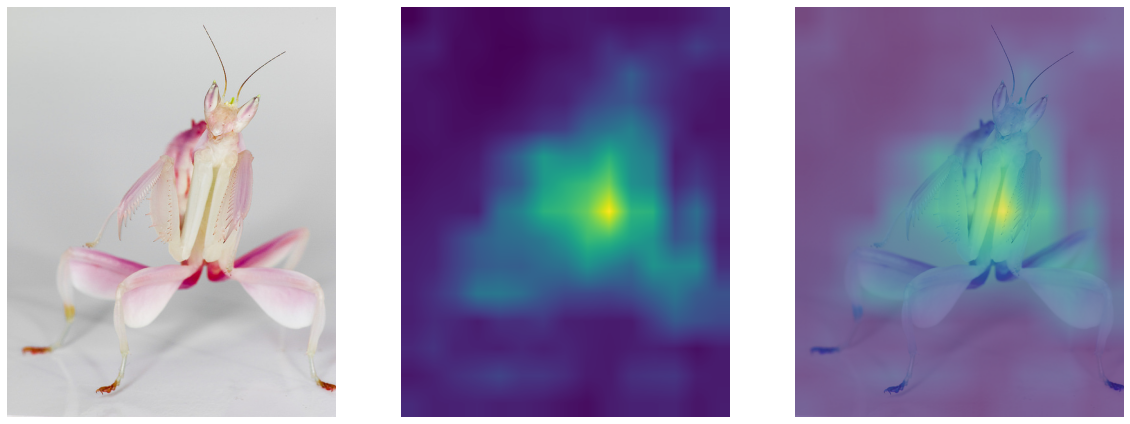

In [165]:
f, ax = plt.subplots(1,3, figsize=(20, 10))

plt.axis('off'); 
ax[0].imshow(orig); 
ax[1].imshow(heatmap); 
ax[2].imshow(output); 
[axi.set_axis_off() for axi in ax.ravel()];

### What else EfficientNetV2L sees in the image 

In [166]:
decoded = imagenet_utils.decode_predictions(preds, 1000)[0]

In [167]:
idx = [s for _, s, _ in decoded[:]].index('walking_stick')

In [168]:
decoded[idx]

('n02231487', 'walking_stick', 0.0054960493)

In [169]:
for l in efficientnetv2l_gc.model.layers[-25:]:
  print(l.name)

block7f_project_conv
block7f_project_bn
block7f_drop
block7f_add
block7g_expand_conv
block7g_expand_bn
block7g_expand_activation
block7g_dwconv2
block7g_bn
block7g_activation
block7g_se_squeeze
block7g_se_reshape
block7g_se_reduce
block7g_se_expand
block7g_se_excite
block7g_project_conv
block7g_project_bn
block7g_drop
block7g_add
top_conv
top_bn
top_activation
avg_pool
top_dropout
predictions


In [175]:
efficientnetv2l_gc = GradCAM(model=efficientnetv2l_model, classIdx=idx)

In [176]:
heatmap = efficientnetv2l_gc.compute_heatmap(image, verbose=True)
# resize the resulting heatmap to the original input image dimensions
# overlay heatmap on top of the image
heatmap = cv2.resize(heatmap, (orig.shape[1], orig.shape[0]))
(heatmap, output) = efficientnetv2l_gc.overlay_heatmap(heatmap, orig, alpha=0.35)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)  
output = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)  


Step 1:
Model: efficientnetv2-l
Conv layerName: top_activation
Conv Layer Shape: (None, 15, 15, 1280)

Step 2:
loss: tf.Tensor([0.00010484], shape=(1,), dtype=float32)
convOutputs shape; (1, 15, 15, 1280)
gradients shape: (1, 15, 15, 1280)

Step 3
guidedGrads shape (1, 15, 15, 1280)
guidedGrads shape batch removal (15, 15, 1280)
convOutputs shape batch removal (15, 15, 1280)

Step 4:
weights shape: (1280,)
cam shape: (15, 15)

Step 5:
heatmap shape: (480, 480)


### The "walking stick"

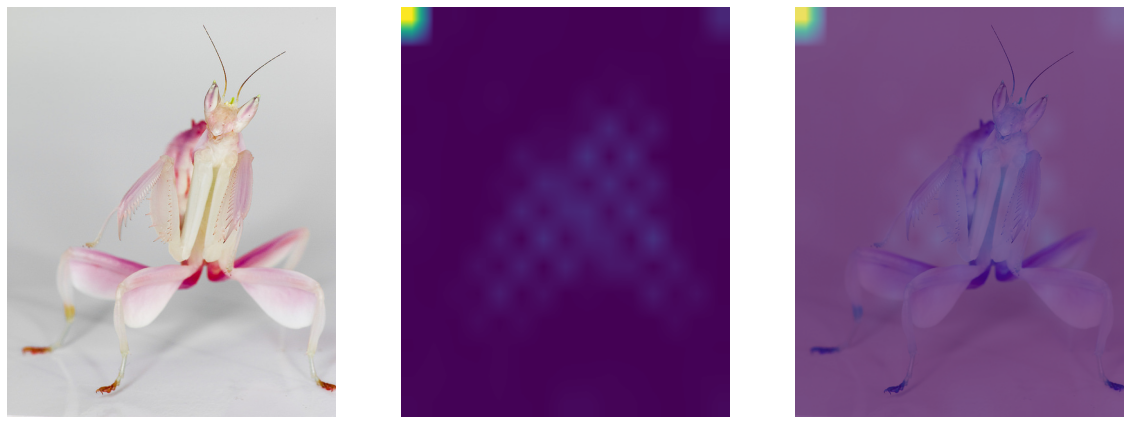

In [177]:
f, ax = plt.subplots(1,3, figsize=(20, 10))

plt.axis('off'); 
ax[0].imshow(orig); 
ax[1].imshow(heatmap); 
ax[2].imshow(output); 
[axi.set_axis_off() for axi in ax.ravel()];